In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime  # Import for dynamic date handling

# List of stock symbols
stock_symbols = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "META", "NVDA", "NFLX", "AMD", "INTC"]

# Updated Date Range
start_date = "2010-01-01"
end_date = datetime.today().strftime("%Y-%m-%d") 

# Create an empty list to store DataFrames
all_data = []

# Loop through each stock and download data
for stock in tqdm(stock_symbols, desc="Downloading Stock Data"):
    df = yf.download(stock, start=start_date, end=end_date)

    # Add Stock Symbol
    df["Stock"] = stock

    
    # Drop NaN values
    df.dropna(inplace=True)

    # Reset index to make Date a column
    df.reset_index(inplace=True)

    # Append to list
    all_data.append(df)

# Combine all stock data into a single DataFrame
final_df = pd.concat(all_data)

# Convert to long format
final_df = final_df.melt(id_vars=["Date", "Stock"], var_name="Feature", value_name="Value")

# Pivot to ensure each feature gets its own column
final_df = final_df.pivot_table(index=["Date", "Stock"], columns="Feature", values="Value").reset_index()

# Save dataset
final_df.to_csv("./data/stock_data_long.csv", index=False)

# Print dataset info
print(f"Dataset saved as 'stock_data_long.csv' from {start_date} to {end_date}!")
print(final_df.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completedt]
[*********************100%***********************]  1 of 1 completedt]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]
[*********************100%***********************]  1 of 1 completeds]


Dataset saved as 'stock_data_long.csv' from 2010-01-01 to 2025-03-23!
Feature       Date  Stock      Close       High        Low       Open  \
0       2010-01-04   AAPL   6.440330   6.455075   6.391277   6.422875   
1       2010-01-04    AMD   9.700000   9.900000   9.680000   9.790000   
2       2010-01-04   AMZN   6.695000   6.830500   6.657000   6.812500   
3       2010-01-04  GOOGL  15.609803  15.678544  15.547290  15.614784   
4       2010-01-04   INTC  13.519426  13.616550  13.422304  13.461154   

Feature       Volume  
0        493729600.0  
1         18748700.0  
2        151998000.0  
3         78169752.0  
4         47800900.0  


Final dataset saved as 'final_stock_data.csv' with all merged fields


/tmp/ipykernel_8732/829821532.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(stocks))


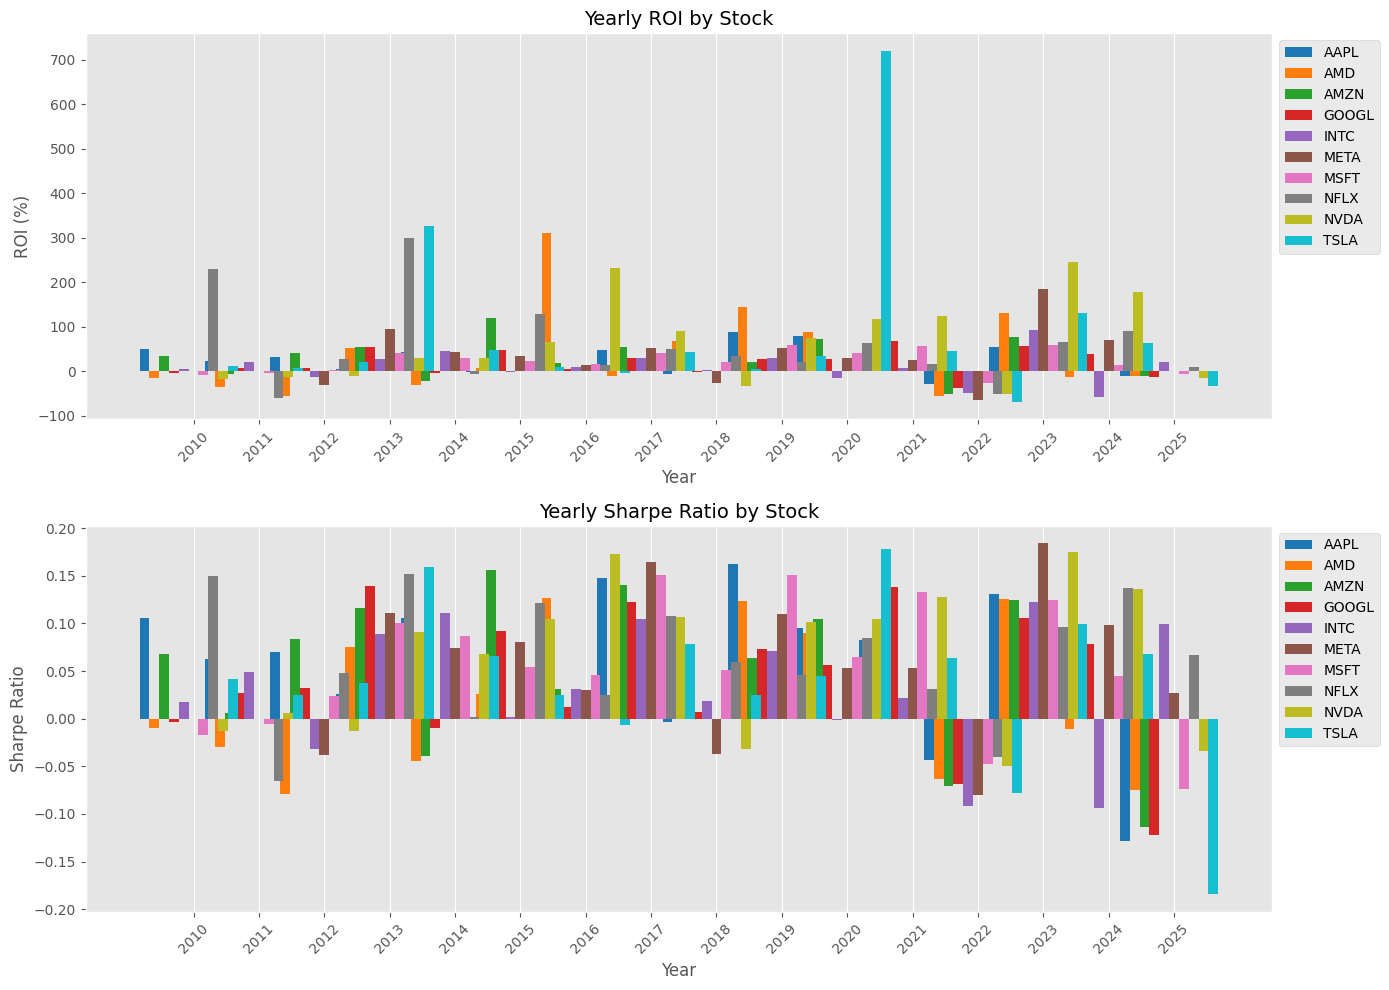

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# Load the original dataset with stock data
stock_data = pd.read_csv("./data/stock_data_long.csv", parse_dates=["Date"])

# Ensure 'Close' price and 'Daily_Return' exist
stock_data["Daily_Return"] = stock_data.groupby("Stock")["Close"].pct_change()

# Extract year from Date column
stock_data["Year"] = stock_data["Date"].dt.year

# Group by Stock & Year for ROI and Sharpe Ratio calculations
yearly_metrics = stock_data.groupby(["Stock", "Year"]).agg(
    Initial_Close=("Close", "first"),
    Final_Close=("Close", "last"),
    Mean_Return=("Daily_Return", "mean"),
    Std_Return=("Daily_Return", "std")
)

# Risk-Free Rate assumption (0%)
risk_free_rate = 0

# Compute yearly ROI and Sharpe Ratio
yearly_metrics["ROI"] = ((yearly_metrics["Final_Close"] - yearly_metrics["Initial_Close"]) / 
                         yearly_metrics["Initial_Close"]) * 100
yearly_metrics["Sharpe_Ratio"] = (yearly_metrics["Mean_Return"] - risk_free_rate) / yearly_metrics["Std_Return"]

# Drop NaN values
yearly_metrics.dropna(inplace=True)

# Reset index for better visualization
yearly_metrics.reset_index(inplace=True)

# --- Merge all fields into one dataset ---
merged_data = stock_data.merge(yearly_metrics, on=["Stock", "Year"], how="left")

# Save final dataset with all fields
merged_data.to_csv("./data/final_stock_data.csv", index=False)
print("Final dataset saved as 'final_stock_data.csv' with all merged fields")

# --- Visualization using Matplotlib ---
plt.style.use("ggplot")  # Better visual style
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Define unique stocks and colors
stocks = yearly_metrics["Stock"].unique()
years = np.sort(yearly_metrics["Year"].unique())
colors = plt.cm.get_cmap("tab10", len(stocks))

width = 0.15  # Width of bars
x_positions = np.arange(len(years))  # X positions for the bars

# ROI Bar Graph
for idx, stock in enumerate(stocks):
    data = yearly_metrics[yearly_metrics["Stock"] == stock].set_index("Year").reindex(years).reset_index()
    axes[0].bar(x_positions + (idx * width), data["ROI"], width=width, label=stock, color=colors(idx))

axes[0].set_xticks(x_positions + (width * len(stocks) / 2))  # Center tick labels
axes[0].set_xticklabels(years, rotation=45)
axes[0].set_title("Yearly ROI by Stock", fontsize=14)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("ROI (%)")
axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1))
axes[0].grid(axis="y")

# Sharpe Ratio Bar Graph
for idx, stock in enumerate(stocks):
    data = yearly_metrics[yearly_metrics["Stock"] == stock].set_index("Year").reindex(years).reset_index()
    axes[1].bar(x_positions + (idx * width), data["Sharpe_Ratio"], width=width, label=stock, color=colors(idx))

axes[1].set_xticks(x_positions + (width * len(stocks) / 2))
axes[1].set_xticklabels(years, rotation=45)
axes[1].set_title("Yearly Sharpe Ratio by Stock", fontsize=14)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))
axes[1].grid(axis="y")

plt.tight_layout()
plt.show()
